In [177]:
import numpy as np
import scipy.optimize as opt
import numpy as np
from scipy.optimize import root

In [178]:
rho_tank=0.0027 #kg/m3
rho_tank=rho_tank*1000000
m=10000#kg
P=172#bar
T=273.15+25
Tref=10+273.15
Po=31.026
tipo='hemi' # 'hemi' or 'semi'

In [179]:
import pandas as pd
crit=pd.DataFrame()
crit['Comp']=['H2']
crit['Tc']=[32.938]
crit['Pc']=[1293.00]
crit['w']=[-0.2160]
crit['PM']=[1.00784*2]
P1=Po
def PRv2(Tc,Pc,mm,w,T,P):
    #Unidades: P, Pc: kPa, T, Tc: K, w: Adim, mm: kg/kmol
    R=8.314#J/mol-K
    Ru=R/mm
    mi=0.379642+1.48503*w-0.164423*w**2+0.016666*w**3
    alpha=(1+mi*(1-(T/Tc)**0.5))**2
    a=0.45724*((Ru)**2)*(Tc**2)*alpha/(Pc)
    b=0.0778*(Ru)*(Tc/Pc)
    A_may=a*P/(((Ru)**2)*(T**2))
    B_may=b*P/((Ru)*T)
    m=-(1-B_may)
    n=(A_may-(3*B_may**2)-(2*B_may))
    o=-((A_may*B_may)-(B_may**2)-(B_may**3))
    v=(Ru*T)/P
    return {'alpha':alpha,'a':a,'b':b,'A':A_may,'B':B_may,'m':m,'n':n,'o':o,'v':v}
resul_peng=PRv2(crit['Tc'][0],crit['Pc'][0],crit['PM'][0],crit['w'][0],316+273.15,172.37*100)
z=np.real(max(np.roots([1,resul_peng['m'],resul_peng['n'],resul_peng['o']])))
r1=(P1*crit['PM'][0])/(z*(8.314)*(T+273.15))
V1=m/r1
V1

np.float64(795317.6073048172)

In [180]:


# ---------------------------
# Parámetros iniciales y constantes
# ---------------------------
# Puedes ajustar estos valores según tu aplicación.
# En este ejemplo, se definirán algunos valores de ejemplo para P, m y T.
# (Ten en cuenta que en tu código original probablemente ya estén definidos.)
P = P * 100000  # convertir a Pascales.
T = 300         # temperatura en Kelvin.

rho_tank=rho_tank   # kg/m3

# Factor y variables usados en los cálculos de volumen (según tu ecuación original)
Z = 0.99704 + P * (6.4149e-9)
V_objetivo = (4157.2 * Z * m * T) / P  # Volumen objetivo calculado (m³)
V=V_objetivo
P1=172.37
resul_peng=PRv2(crit['Tc'][0],crit['Pc'][0],crit['PM'][0],crit['w'][0],T,(P/100000)*100)
z=np.real(max(np.roots([1,resul_peng['m'],resul_peng['n'],resul_peng['o']])))
r1=(100*P1*crit['PM'][0])/(z*(8.314)*(T))
V1=m/r1
V=V1
V_objetivo=V
#print('obj',V_objetivo)
# Valor inicial para la iteración: x[0] será r y x[1] será L.
x0 = [1.5, 3.0]  # Ejemplo: r=1.5 m y L=3.0 m

# ---------------------------
# Definición del sistema de ecuaciones
# ---------------------------
def ecuaciones(x, V_obj):
    r, L = x[0], x[1]
    # Volumen del cilindro
    if tipo == 'hemi':
        V_tank = (4 / 3) * np.pi * r**3 + (L - 2*r) * np.pi * r**2
    elif tipo == 'semi':
        V_tank = np.pi * r**2 * L + (2/3) * np.pi * r**3
    else:
        raise ValueError("Tipo de tanque no reconocido. Usa 'hemi' o 'semi'.")
    
    # Primera ecuación: el volumen total debe coincidir con V_objetivo.
    f1 = V_tank - V_obj
    # Segunda ecuación: imponer la relación de diseño entre L y r.
    f2 = L - 3.1 * r
    return [f1, f2]

# ---------------------------
# Resolver el sistema usando la función root con el método 'hybr'
# ---------------------------
solucion = root(ecuaciones, x0=x0, args=(V_objetivo,), method='hybr', tol=1e-3)

if solucion.success:
    global L_encontrado
    global V_cilindro_sol
    global V_total_sol
    global mt
    global t
    r, L_encontrado = solucion.x[0], solucion.x[1]
    # Cálculo de volúmenes usando los valores encontrados.
    if tipo == 'hemi':
        V_total_sol = (4 / 3) * np.pi * r**3 + (L_encontrado - 2*r) * np.pi * r**2
    elif tipo == 'semi':
        V_total_sol = (2 / 3) * np.pi * r**3 + (L_encontrado - r) * np.pi * r**2
    else:
        raise ValueError("Tipo de tanque no reconocido. Usa 'hemi' o 'semi'.")

    #print("Volumen objetivo:", V_objetivo, "m3")
    print("Volumen calculado del tanque:", round(V_total_sol,2), "m3")
    print("Radio del tanque:", round(r,2), "m")
    print("Longitud del tanque:", round(L_encontrado,2), "m")

    # ---------------------------
    # Ejemplo de cálculo del espesor (usando una ecuación de pared delgada)
    # ---------------------------
    # Aquí se usa la ecuación: t = (P * r * FS) / (2 * sigma)
    # Por ejemplo, si FS = 1.5:
    FS = 1.5
    Sy = 2811*100000
    Su = 3095*100000
    #ASME Boiler & Pressure Vessel Code, Sección VIII, División 1.
    t1 = (P * r * FS) / (Sy)
    t2 = (P * r * 2.25) / (Su)
    t = max([t1,t1])
    print("Espesor del tanque:", round(t*1000,2), "mm")
    h=r

    # ---------------------------
    # Ejemplo de cálculo de la masa del tanque.
    # Supongamos que la masa se calcula considerando un incremento de r (r + t)
    # y que el volumen se compone de la esfera engrosada y el cilindro engrosado.
    if tipo == 'hemi':
        mt = rho_tank * ( (4/3) * np.pi * (r + t)**3 + np.pi * (r + t)**2 * L_encontrado - V_objetivo )
        mt = mt / 1000  # conversión a toneladas
    elif tipo == 'semi':
       mt = rho_tank * (np.pi * ((r+t)**2 * L_encontrado + (2/3) * (r+t)**2 * (h+t)) - (np.pi * r**2 * L_encontrado + (2/3) * np.pi * r**2 * h))
       mt = mt / 1000  # conversión a toneladas
    else:
        raise ValueError("Tipo de tanque no reconocido. Usa 'hemi' o 'semi'.")
    
    print("Masa del tanque:", round(mt,2), "ton")
else:
    print("No se encontró solución:", solucion.message)


Volumen calculado del tanque: 770.04 m3
Radio del tanque: 4.65 m
Longitud del tanque: 14.42 m
Espesor del tanque: 427.05 mm
Masa del tanque: 2560.75 ton


In [181]:
class TankCostCalculator:
    price_per_lb_gas = {
        "Type I": 5.5,
        "Type II": 9.0,
        "Type III & IV": 15.5
    }

    def __init__(self, tank_type, gas_mass_kg):
        self.tank_type = tank_type
        self.gas_mass_kg = gas_mass_kg
        self.gas_mass_lb = gas_mass_kg * 2.20462  # in lb
        self.price_per_lb = self.price_per_lb_gas[tank_type]
        self.extras_df = self.calculate_cost()  # Call calculate_cost during initialization

    def calculate_cost(self):
        CEPCI_2014 = 576.1
        CEPCI_2024 = 798.8
        self.price= (self.gas_mass_lb * self.price_per_lb)* (CEPCI_2024 / CEPCI_2014)
        self.total_material_cost= self.price * 1.2  
        self.construction= self.price * 0.08
        installation_cost = self.price * 2.5
        instrumentation_cost = self.price * 0.08
        Final_cost = self.price + self.total_material_cost + self.construction + installation_cost + instrumentation_cost
        cost_mxn= Final_cost * 19.61  

        # Create a data frame with the extra costs
        extras = {
            "Total Price (FOB)": [self.price],
            "Installation Cost (USD)": [installation_cost],
            "Total Material Cost (USD)": [self.total_material_cost],
            "Construction Cost (USD)": [self.construction],
            "Instrumentation Cost (USD)": [instrumentation_cost],
            "Final Cost (USD)": [Final_cost],
            "Final Cost (MXN)": [cost_mxn]
        }
        self.extras_df = pd.DataFrame(extras)
        # Format the numbers in the extras_df as currency
        self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)       
        return  self.extras_df


T1="Type I"
T2="Type II"
T3="Type III & IV"

In [182]:
Pes=np.linspace(400,2000)

In [183]:
tank,price,Vv,Tt,Rr,Ll=[],[],[],[],[],[]

In [184]:
tank_type = T1

In [185]:
for i in range(len(Pes)):
    # ---------------------------
    # Parámetros iniciales y constantes
    # ---------------------------
    # Puedes ajustar estos valores según tu aplicación.
    # En este ejemplo, se definirán algunos valores de ejemplo para P, m y T.
    # (Ten en cuenta que en tu código original probablemente ya estén definidos.)
    P = Pes[i] * 100000  # convertir a Pascales.
    T = 300         # temperatura en Kelvin.


    rho_tank=rho_tank   # kg/m3

    # Factor y variables usados en los cálculos de volumen (según tu ecuación original)
    Z = 0.99704 + P * (6.4149e-9)
    V_objetivo = (4157.2 * Z * m * T) / P  # Volumen objetivo calculado (m³)
    V=V_objetivo
    P1=P/100000
    resul_peng=PRv2(crit['Tc'][0],crit['Pc'][0],crit['PM'][0],crit['w'][0],T,(P/100000)*100)
    z=np.real(max(np.roots([1,resul_peng['m'],resul_peng['n'],resul_peng['o']])))
    r1=(100*P1*crit['PM'][0])/(z*(8.314)*(T))
    V1=m/r1
    V=V1
    V_objetivo=V
    #print('obj',V_objetivo)
    # Valor inicial para la iteración: x[0] será r y x[1] será L.
    x0 = [1.5, 3.0]  # Ejemplo: r=1.5 m y L=3.0 m

    # ---------------------------
    # Definición del sistema de ecuaciones
    # ---------------------------
    def ecuaciones(x, V_obj):
        r, L = x[0], x[1]
        # Volumen del cilindro
        if tipo == 'hemi':
            V_tank = (4 / 3) * np.pi * r**3 + (L - 2*r) * np.pi * r**2
        elif tipo == 'semi':
            V_tank = np.pi * r**2 * L + (2/3) * np.pi * r**3
        else:
            raise ValueError("Tipo de tanque no reconocido. Usa 'hemi' o 'semi'.")
        
        # Primera ecuación: el volumen total debe coincidir con V_objetivo.
        f1 = V_tank - V_obj
        # Segunda ecuación: imponer la relación de diseño entre L y r.
        f2 = L - 3.1 * r
        return [f1, f2]

    # ---------------------------
    # Resolver el sistema usando la función root con el método 'hybr'
    # ---------------------------
    solucion = root(ecuaciones, x0=x0, args=(V_objetivo,), method='hybr', tol=1e-3)

    if solucion.success:
        global L_encontrado
        global V_cilindro_sol
        global V_total_sol
        global mt
        global t
        r, L_encontrado = solucion.x[0], solucion.x[1]
        # Cálculo de volúmenes usando los valores encontrados.
        if tipo == 'hemi':
            V_total_sol = (4 / 3) * np.pi * r**3 + (L_encontrado - 2*r) * np.pi * r**2
        elif tipo == 'semi':
            V_total_sol = (2 / 3) * np.pi * r**3 + (L_encontrado - r) * np.pi * r**2
        else:
            raise ValueError("Tipo de tanque no reconocido. Usa 'hemi' o 'semi'.")

        #print("Volumen objetivo:", V_objetivo, "m3")
        print("Volumen calculado del tanque:", round(V_total_sol,2), "m3")
        print("Radio del tanque:", round(r,2), "m")
        print("Longitud del tanque:", round(L_encontrado,2), "m")

        # ---------------------------
        # Ejemplo de cálculo del espesor (usando una ecuación de pared delgada)
        # ---------------------------
        # Aquí se usa la ecuación: t = (P * r * FS) / (2 * sigma)
        # Por ejemplo, si FS = 1.5:
        FS = 1.5
        Sy = 2811*100000
        Su = 3095*100000
        #ASME Boiler & Pressure Vessel Code, Sección VIII, División 1.
        t1 = (P * r * FS) / (Sy)
        t2 = (P * r * 2.25) / (Su)
        t = max([t1,t1])
        print("Espesor del tanque:", round(t*1000,2), "mm")
        h=r
        Tt.append(t)
        Rr.append(r)
        Ll.append(L_encontrado)

        # ---------------------------
        # Ejemplo de cálculo de la masa del tanque.
        # Supongamos que la masa se calcula considerando un incremento de r (r + t)
        # y que el volumen se compone de la esfera engrosada y el cilindro engrosado.
        if tipo == 'hemi':
            mt = rho_tank * ( (4/3) * np.pi * (r + t)**3 + np.pi * (r + t)**2 * L_encontrado - V_objetivo )
            mt = mt / 1000  # conversión a toneladas
        elif tipo == 'semi':
            mt = rho_tank * (np.pi * ((r+t)**2 * L_encontrado + (2/3) * (r+t)**2 * (h+t)) - (np.pi * r**2 * L_encontrado + (2/3) * np.pi * r**2 * h))
            mt = mt / 1000  # conversión a toneladas
        else:
            raise ValueError("Tipo de tanque no reconocido. Usa 'hemi' o 'semi'.")
        
        print("Masa del tanque:", round(mt,2), "ton")
    else:
        print("No se encontró solución:", solucion.message)
    gas_mass = mt   # in ton
    calculator1 = TankCostCalculator(tank_type, gas_mass)
    tank.append(mt)
    Vv.append(V)
    price.append(calculator1.extras_df['Final Cost (MXN)'][0])

Volumen calculado del tanque: 371.28 m3
Radio del tanque: 3.65 m
Longitud del tanque: 11.31 m
Espesor del tanque: 778.77 mm
Masa del tanque: 1859.47 ton
Volumen calculado del tanque: 348.9 m3
Radio del tanque: 3.57 m
Longitud del tanque: 11.08 m
Espesor del tanque: 825.07 mm
Masa del tanque: 1838.82 ton
Volumen calculado del tanque: 329.73 m3
Radio del tanque: 3.51 m
Longitud del tanque: 10.87 m
Espesor del tanque: 870.77 mm
Masa del tanque: 1825.94 ton
Volumen calculado del tanque: 313.12 m3
Radio del tanque: 3.45 m
Longitud del tanque: 10.69 m
Espesor del tanque: 915.96 mm
Masa del tanque: 1819.41 ton
Volumen calculado del tanque: 298.6 m3
Radio del tanque: 3.39 m
Longitud del tanque: 10.52 m
Espesor del tanque: 960.7 mm
Masa del tanque: 1818.16 ton
Volumen calculado del tanque: 285.8 m3
Radio del tanque: 3.34 m
Longitud del tanque: 10.37 m
Espesor del tanque: 1005.03 mm
Masa del tanque: 1821.35 ton
Volumen calculado del tanque: 274.43 m3
Radio del tanque: 3.3 m
Longitud del tanque: 

/tmp/ipykernel_7361/2882359236.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)


In [186]:
resultados=pd.DataFrame()
resultados['P (bar)']=Pes
resultados['Mt (ton)']=tank
resultados['Vt (m3)']=Vv
resultados['Espesor']=Tt
resultados['Radio (m)']=Rr
resultados['Longitud (m)']=Ll
resultados['Final price (MXN)']=price


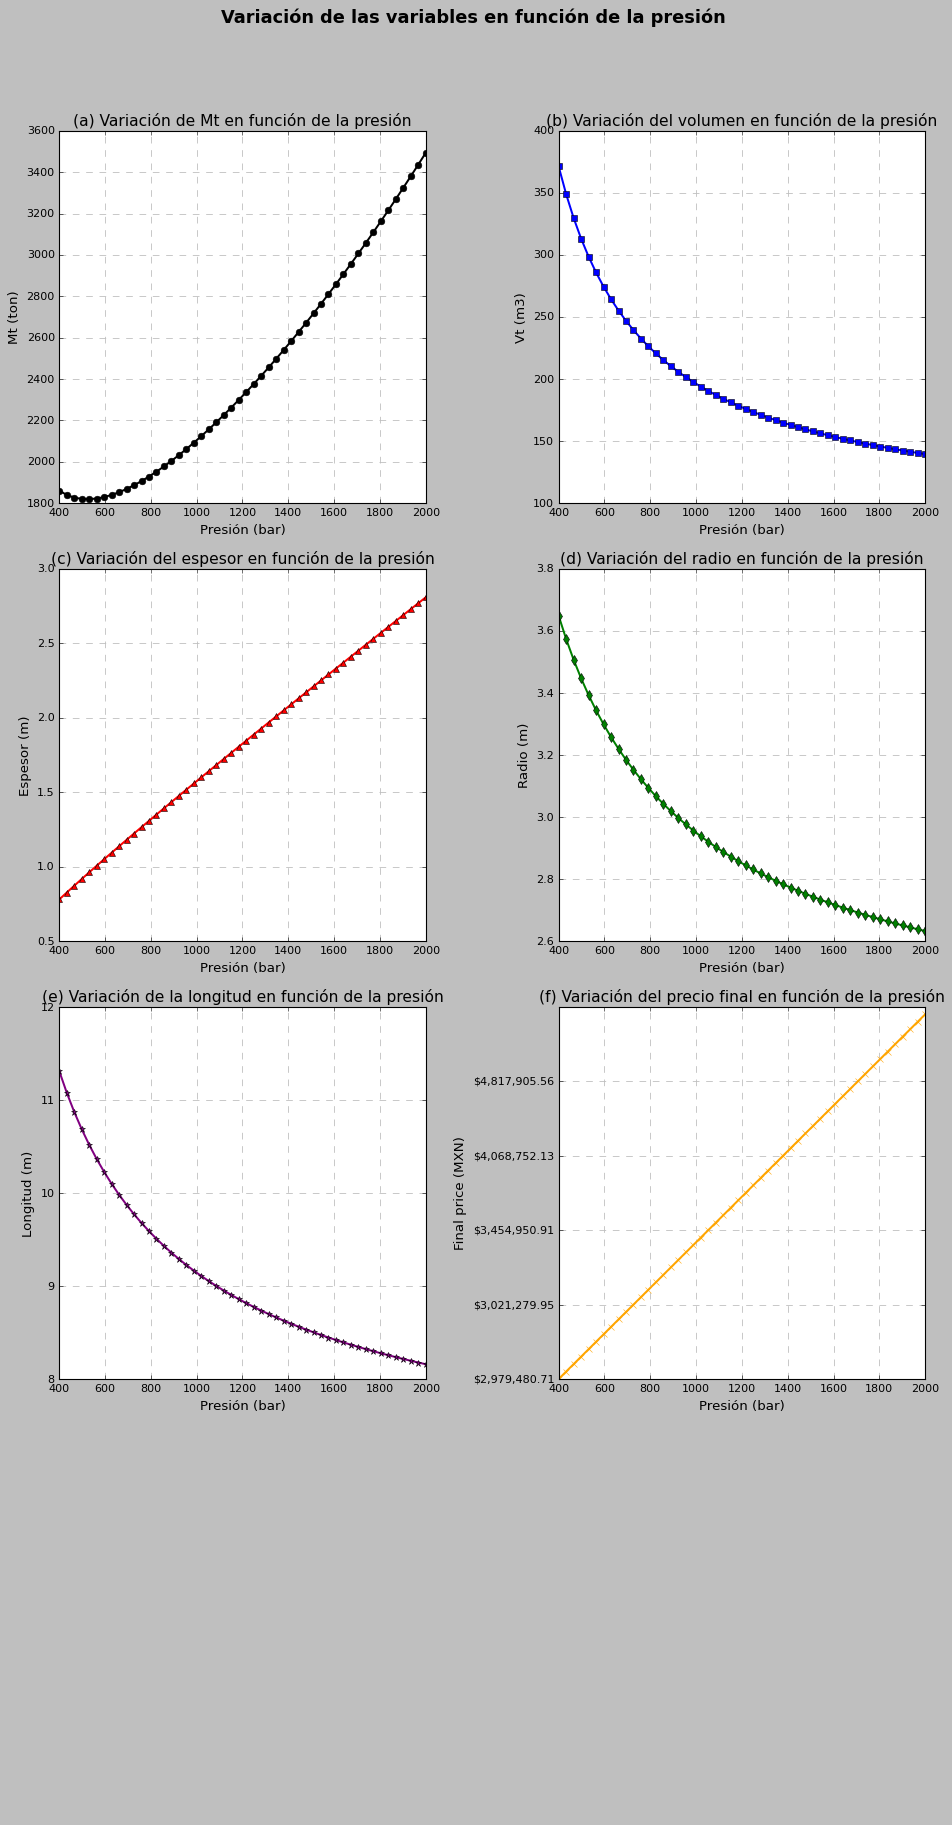

In [187]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker  # Para controlar la cantidad de ticks en el eje y

# Aplicamos el estilo clásico y actualizamos algunos parámetros estéticos
plt.style.use('classic')
plt.rcParams.update({
    'font.size': 12,             # Tamaño global de fuente
    'axes.labelsize': 12,        # Tamaño de las etiquetas de los ejes
    'axes.titlesize': 14,        # Tamaño de los títulos de los ejes
    'xtick.labelsize': 10,       # Tamaño de las etiquetas del eje x
    'ytick.labelsize': 10,       # Tamaño de las etiquetas del eje y
    'lines.linewidth': 1.8,      # Grosor de las líneas
    'lines.markersize': 6,       # Tamaño de los marcadores
    'grid.linestyle': '--',      # Estilo discontínuo para la rejilla
    'grid.linewidth': 0.75,      # Grosor de la rejilla
    'grid.color': '0.75',        # Color gris para la rejilla
})

# Nuevos datos
resultados = pd.DataFrame({
    'P (bar)': Pes,
    'Mt (ton)': tank,
    'Vt (m3)': Vv,
    'Espesor': Tt,
    'Radio (m)': Rr,
    'Longitud (m)': Ll,
    'Final price (MXN)': price
})

# Configuración de la figura con 4 filas y 2 columnas
fig, axs = plt.subplots(4, 2, figsize=(12, 24))
fig.suptitle('Variación de las variables en función de la presión', fontsize=16, fontweight='bold')

# Panel (a): Mt (ton) vs. Presión
axs[0, 0].plot(resultados['P (bar)'], resultados['Mt (ton)'],
               marker='o', linestyle='-', color='black')
axs[0, 0].set_ylabel('Mt (ton)')
axs[0, 0].set_title('(a) Variación de Mt en función de la presión')
axs[0, 0].grid(True)
axs[0, 0].set_axisbelow(True)
axs[0, 0].set_xlabel('Presión (bar)')

# Panel (b): Vt (m3) vs. Presión
axs[0, 1].plot(resultados['P (bar)'], resultados['Vt (m3)'],
               marker='s', linestyle='-', color='blue')
axs[0, 1].set_ylabel('Vt (m3)')
axs[0, 1].set_title('(b) Variación del volumen en función de la presión')
axs[0, 1].grid(True)
axs[0, 1].set_axisbelow(True)
axs[0, 1].set_xlabel('Presión (bar)')

# Panel (c): Espesor vs. Presión
axs[1, 0].plot(resultados['P (bar)'], resultados['Espesor'],
               marker='^', linestyle='-', color='red')
axs[1, 0].set_ylabel('Espesor (m)')
axs[1, 0].set_title('(c) Variación del espesor en función de la presión')
axs[1, 0].grid(True)
axs[1, 0].set_axisbelow(True)
axs[1, 0].set_xlabel('Presión (bar)')

# Panel (d): Radio (m) vs. Presión
axs[1, 1].plot(resultados['P (bar)'], resultados['Radio (m)'],
               marker='d', linestyle='-', color='green')
axs[1, 1].set_ylabel('Radio (m)')
axs[1, 1].set_title('(d) Variación del radio en función de la presión')
axs[1, 1].grid(True)
axs[1, 1].set_axisbelow(True)
axs[1, 1].set_xlabel('Presión (bar)')

# Panel (e): Longitud (m) vs. Presión
axs[2, 0].plot(resultados['P (bar)'], resultados['Longitud (m)'],
               marker='*', linestyle='-', color='purple')
axs[2, 0].set_ylabel('Longitud (m)')
axs[2, 0].set_title('(e) Variación de la longitud en función de la presión')
axs[2, 0].grid(True)
axs[2, 0].set_axisbelow(True)
axs[2, 0].set_xlabel('Presión (bar)')
# Reducir el número de ticks en el eje y a un máximo de 5 para el gráfico de Longitud
axs[2, 0].yaxis.set_major_locator(ticker.MaxNLocator(5))

# Panel (f): Final price (MXN) vs. Presión
axs[2, 1].plot(resultados['P (bar)'], resultados['Final price (MXN)'],
               marker='x', linestyle='-', color='orange')
axs[2, 1].set_ylabel('Final price (MXN)')
axs[2, 1].set_title('(f) Variación del precio final en función de la presión')
axs[2, 1].grid(True)
axs[2, 1].set_axisbelow(True)
axs[2, 1].set_xlabel('Presión (bar)')
# Reducir el número de ticks en el eje y a un máximo de 5 para el gráfico de Final price
axs[2, 1].yaxis.set_major_locator(ticker.MaxNLocator(5))

# Ocultamos los paneles vacíos restantes
for ax in axs.flat:
    if not ax.has_data():
        ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [188]:
P1=Po
P2=P
N_etapas=np.ceil((np.log(P2)/np.log(P1))/np.log(2))
N_etapas

np.float64(9.0)

In [189]:
def Cp_Cv(T):
        return 1.5949974007561318 * T ** (-0.021034016066268504)
def compressor_power(m_dot, T1, P_ratio, gamma, cp, eta):
    """
    Calcula la potencia requerida por un compresor para la compresión adiabática de un gas.

    Parámetros:
      m_dot : float
          Caudal másico del gas (kg/s).
      T1 : float
          Temperatura de entrada al compresor (K).
      P_ratio : float
          Relación de presión (P2 / P1, sin unidades) a la que se desea comprimir.
      gamma : float
          Relación de calores específicos (Cp/Cv).
      cp : float
          Calor específico a presión constante (J/kg·K).
      eta : float
          Eficiencia del compresor (valor entre 0 y 1).

    Retorna:
      power : float
          Potencia del compresor requerida (W, vatios).
    """
    # Cálculo del trabajo específico en J/kg
    specific_work = (cp * T1 * gamma / (gamma - 1)) * ((P_ratio)**((gamma - 1) / gamma) - 1)
    
    # Potencia requerida = caudal másico * trabajo específico, corregido por la eficiencia
    power = m_dot * specific_work / eta
    return power/1000

# Ejemplo de uso:
if __name__ == "__main__":
    # Parámetros de entrada (se pueden ajustar según el caso particular)
    T1      = 300           # Temperatura de entrada en Kelvin
    P_ratio = 10            # Relación de presiones (por ejemplo, de 1 a 10)
    gamma   = 1.40          # Relación de calores específicos (puede variar para hidrógeno, p.ej., ~1.40 en bajas temperaturas)
    cp      = 14300         # Calor específico de hidrógeno a presión constante (J/kg·K). Nota: El valor de hidrógeno es mayor debido a su baja masa molar.
    eta     = 0.75          # Eficiencia del compresor (75%)

    CP=19.67099783 + 0.069681519*T - 0.000200098*T**2 + 2.89493E-07*T**3 - 2.22475E-10*T**4 + 8.81466E-14*T**5 - 1.42043E-17*T**6
    CP=CP/2*1000
    
    
    power_required = compressor_power(m, T, P_ratio, Cp_Cv(T), CP, eta)
    print(f"La potencia requerida para la compresión es: {power_required:.2f} kW")


La potencia requerida para la compresión es: 189313585.51 kW


In [190]:
HhH2=(19.67099783*(T-Tref) + 0.069681519/2*(T**2-Tref**2) - 0.000200098/3*(T**3-Tref**3) + 2.89493E-07/4*(T**4-Tref*4) - 2.22475E-10/5*(T**5-Tref**5) + 8.81466E-14/6*(T**6-Tref**6) - 1.42043E-17/7*(T**6-Tref**6))/2
HhH2

474.6510488485655

In [191]:
HhH2O = (-22.41701677*(T-Tref) + 0.876972156/2*(T**2-Tref**2) -0.002570393/3*(T**3-Tref**3) + 2.48383E-06/4*(T**4-Tref**4))/18.015
HhH2O

71.38708848243724

In [192]:
rho_tank=4500 #kg/m3
m=1000/3600
P=172.37#bar
R=8.314e-5
T=273.15+25
Tref=10+273.15
Po=31.026

In [193]:
import numpy as np
from scipy.optimize import root

def balance(x, T, Tref, m):
    global e
    global s
    """
    Calcula la función de balance para el proceso,
    devolviendo la diferencia e - s.

    Parámetros:
      x    : vector de incógnitas; se asume que x[0] es la variable a encontrar.
      T    : temperatura en K.
      Tref : temperatura de referencia en K.
      m    : masa del hidrógeno (kg).

    La función utiliza dos series polinómicas (para H2 y H2O)
    para calcular, respectivamente, las energías 'e' y 's', y retorna e - s.
    """
    # Calcular la entalpía (u otra propiedad) para hidrógeno
    Ta=15+273.15
    HhH2 = ( 19.67099783*(T - Tref)
              + (0.069681519/2) * (T**2 - Tref**2)
              - (0.000200098/3) * (T**3 - Tref**3)
              + (2.89493E-07/4) * (T**4 - Tref**4)
              - (2.22475E-10/5) * (T**5 - Tref**5)
              + (8.81466E-14/6) * (T**6 - Tref**6)
              - (1.42043E-17/7) * (T**6 - Tref**6)
            ) / 2
    e = HhH2 * m

    # Calcular la entalpía (u otra propiedad) para agua (H2O)
    HhH2O = ( -22.41701677*(Ta - Tref)
               + (0.876972156/2) * (Ta**2 - Tref**2)
               - (0.002570393/3) * (Ta**3 - Tref**3)
               + (2.48383E-06/4) * (Ta**4 - Tref**4)
             ) / 18.015
    s = HhH2O * x[0]
    
    return e - s


In [194]:
P_diff=P-Po
P_etapa=P_diff/N_etapas

In [195]:
Po=Po
Pf=P
P_acum=[Po]
Temps=[300]
Tref=10+273.15
Qs,Ts,m_H2O,comp,power,Ps=[],[],[],[],[],[]
for i in range(int(N_etapas)):
    P1=sum(P_acum)
    P_acum.append(P_etapa)
    P2=sum(P_acum)
    Z = 0.99704 + P * (6.4149e-9)
    V = ((m)/(2)*8.314*Temps[-1])/sum(P_acum)
    V2=V*(P1/P2)**(1/Cp_Cv(Temps[-1]))
    Z = 0.99704 + P2 * 1e6 * (6.4149e-9)
    Ti=(sum(P_acum)*V2*2)/(m*Z*8.314)
    print('T',Ti)
    # Valor inicial para la incógnita x (en este caso, es un vector de una dimensión)
    x0 = [1.0]

    # Se utiliza scipy.optimize.root con método 'hybr'
    solucion = root(balance, x0, args=(25+273.15, Ti, m), method='hybr', tol=1e-1)

    if solucion.success:
        x_encontrado = solucion.x[0]
        print(f"Solución encontrada: x = {x_encontrado:.6f}")
        Temps.append(25+273.15)
        Qs.append(float(e))
        Ts.append((25+273.15))
        m_H2O.append(float(x_encontrado))
        comp.append('No. '+str(i+1))
        CP=19.67099783 + 0.069681519*T - 0.000200098*T**2 + 2.89493E-07*T**3 - 2.22475E-10*T**4 + 8.81466E-14*T**5 - 1.42043E-17*T**6
        CP=CP/2*1000
        power.append(float(compressor_power(m, Ti, P2/P1, Cp_Cv(Ti), CP, 0.75)))
        Ps.append(P2)
    else:
        print("No se encontró solución:", solucion.message)
        


    

T 173.1831088020989
Solución encontrada: x = 1.050779
T 173.8321840005703
Solución encontrada: x = 1.050853
T 169.8099159759158
Solución encontrada: x = 1.050540
T 163.81645959644803
Solución encontrada: x = 1.050692
T 157.23237347207387
Solución encontrada: x = 1.051675
T 150.62938768331966
Solución encontrada: x = 1.053485
T 144.25441316865644
Solución encontrada: x = 1.055997
T 138.21008810810014
Solución encontrada: x = 1.059065
T 132.53105608385334
Solución encontrada: x = 1.062557


In [196]:
import pandas as pd
# Crear un DataFrame con los datos
data = {
	"Compressor": comp,
    "T (K)": Ts,
    "P (bar)": Ps,  # Convertir de Pa a bar
	"Cooling H2O (kg/s)": m_H2O,
	"Q (kW)": Qs,
    "W (kW)": power,
    "Consumption (kW)": np.array(Qs)+ np.array(power)
}

df_compresores = pd.DataFrame(data)
df_compresores.loc[df_compresores.shape[0]] = ["Total", Temps[-1], Ps[-1], sum(m_H2O), sum(Qs), sum(power), sum(Qs)+ sum(power)]

# Mostrar la tabla
df_compresores

,Compressor,T (K),P (bar),Cooling H2O (kg/s),Q (kW),W (kW),Consumption (kW)
0,No. 1,298.15,46.730889,1.050779,487.204807,402.234916,889.439723
1,No. 2,298.15,62.435778,1.050853,484.765211,280.403316,765.168528
2,No. 3,298.15,78.140667,1.050540,499.862134,210.026389,709.888523
3,No. 4,298.15,93.845556,1.050692,522.262157,164.352326,686.614483
4,No. 5,298.15,109.550444,1.051675,546.732318,132.710949,679.443267
5,No. 6,298.15,125.255333,1.053485,571.121288,109.732533,680.853820
6,No. 7,298.15,140.960222,1.055997,594.517080,92.438301,686.955381
7,No. 8,298.15,156.665111,1.059065,616.555922,79.051580,695.607502
8,No. 9,298.15,172.370000,1.062557,637.129910,68.451681,705.581591
9,Total,298.15,172.370000,9.485641,4960.150826,1539.401992,6499.552818
